In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import os
import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from einops import rearrange
from dots.training import *
from dots.trainhooks import *
from dots.datasets import get_dataset
from dots.models import BasicCNN
from dots.dots import *
from dots.utils import *
from dots.plotting import *
from dots.experiment import get_train_state, get_config_dataset

In [3]:
failed = load_model("jolly-sweep-29")
succeeded = load_model("hardy-sweep-27")
ds = get_dataset("mnist")
test_ds = dataset_from_end(ds, 1000)

In [3]:
small_rand = random_batch(4, (1, 28, 28))
small_data = tensor_of_dataset(ds, [0, 1, 2, 3])

same_class_data = class_examples(test_ds, 0, 4)

close_rand = perturbed_copies(random_batch(1, (1, 28, 28))[0], 4)
close_data = perturbed_copies(tensor_of_dataset(ds, [0])[0], 4)

id_data = tensor_of_dataset(ds, [0, 0, 0, 0])

vclose_data = tensor_of_dataset(ds, [0, 0, 0, 0]).clone()
vclose_data[1, 0, 0, 0] += 0.01
vclose_data[2, 0, 0, 1] += 0.01
vclose_data[3, 0, 1, 0] += 0.01

for a in [small_rand, small_data, same_class_data, close_rand, close_data]:
    print(a.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])


In [71]:
same_class_data.shape

torch.Size([4, 1, 28, 28])

In [72]:
def plot_imgs(ds):
    n = len(ds)
    fig, axs = plt.subplots(1, n, figsize=(12, 7))
    for i in range(n):
        axs[i].imshow(ds[i, 0].cpu().numpy().squeeze(), cmap="gray")
        axs[i].axis("off")

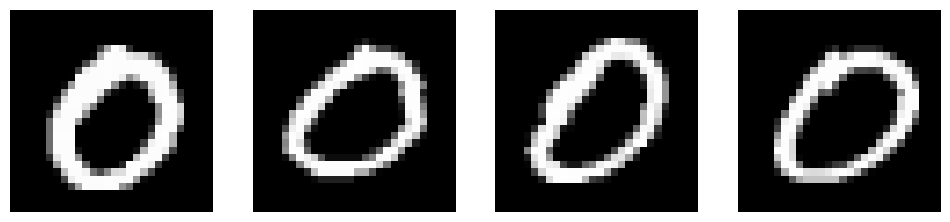

In [73]:
plot_imgs(same_class_data)

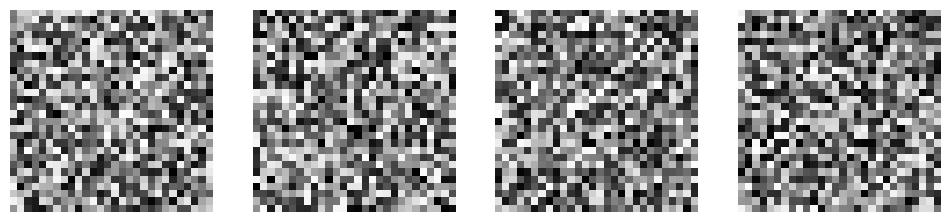

In [74]:
plot_imgs(small_rand)

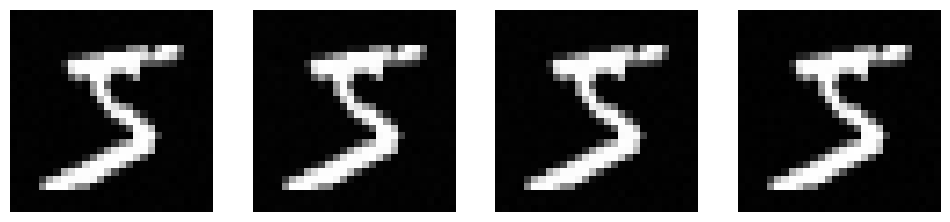

In [75]:
plot_imgs(close_data)

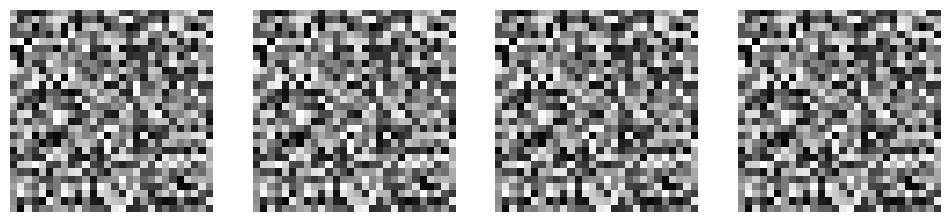

In [76]:
plot_imgs(close_rand)

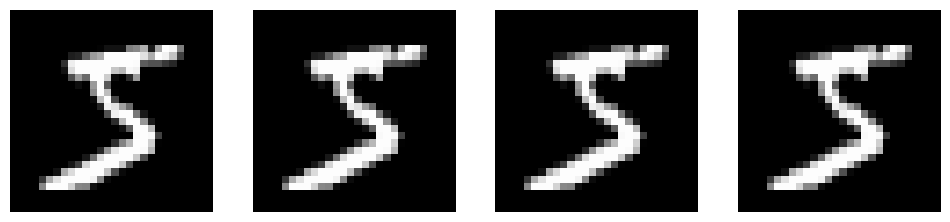

In [81]:
plot_imgs(id_data)

In [77]:
print(f"Accuracy of failed model: {accuracy(failed, test_ds)}")
print(f"Accuracy of succeeded model: {accuracy(succeeded, test_ds)}")

Accuracy of failed model: 0.09399999678134918
Accuracy of succeeded model: 0.9869999885559082


In [78]:
print(f"Rank of Jacobian of failed model: {failed.jacobian_matrix_rank(small_data)}")
print(f"Rank of Jacobian of succeeded model: {succeeded.jacobian_matrix_rank(small_data)}")
print(f"Rank of Jacobian of failed model, rand: {failed.jacobian_matrix_rank(small_rand)}")
print(f"Rank of Jacobian of succeeded model, rand: {succeeded.jacobian_matrix_rank(small_rand)}")

Rank of Jacobian of failed model: 10
Rank of Jacobian of succeeded model: 40
Rank of Jacobian of failed model, rand: 10
Rank of Jacobian of succeeded model, rand: 40


In [79]:
print("WITH CLOSE DATA")
print(f"Rank of Jacobian of failed model: {failed.jacobian_matrix_rank(close_data)}")
print(f"Rank of Jacobian of succeeded model: {succeeded.jacobian_matrix_rank(close_data)}")
print(f"Rank of Jacobian of failed model, rand: {failed.jacobian_matrix_rank(close_rand)}")
print(f"Rank of Jacobian of succeeded model, rand: {succeeded.jacobian_matrix_rank(close_rand)}")

WITH CLOSE DATA
Rank of Jacobian of failed model: 10
Rank of Jacobian of succeeded model: 40
Rank of Jacobian of failed model, rand: 10
Rank of Jacobian of succeeded model, rand: 40


In [85]:
print("WITH ID DATA")
print(f"Rank of Jacobian of failed model: {failed.jacobian_matrix_rank(id_data)}")
print(f"Rank of Jacobian of succeeded model: {succeeded.jacobian_matrix_rank(id_data)}")

WITH ID DATA
Rank of Jacobian of failed model: 10
Rank of Jacobian of succeeded model: 10


In [91]:
print("WITH VERY CLOSE (1 pixel different) DATA")
print(f"Rank of Jacobian of failed model: {failed.jacobian_matrix_rank(vclose_data)}")
print(f"Rank of Jacobian of succeeded model: {succeeded.jacobian_matrix_rank(vclose_data)}")

WITH VERY CLOSE (1 pixel different) DATA
Rank of Jacobian of failed model: 10
Rank of Jacobian of succeeded model: 10


In [224]:
def with_changed_pixel(tensor, change_amount=0.1):
    new_tensor = tensor.clone()
    random_index = tuple(t.randint(0, dim_size, (1,)).item() for dim_size in tensor.shape)
    new_tensor[random_index] += change_amount
    return new_tensor

In [118]:
two = tensor_of_dataset(ds, [0, 0]).clone()
two.shape

torch.Size([2, 1, 28, 28])

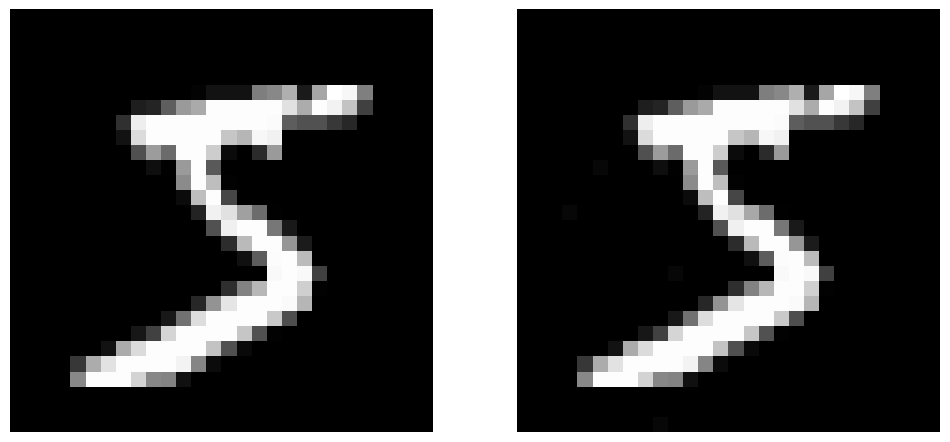

In [125]:
plot_imgs(two)

In [136]:
(~(two[0] == two[1])).view(-1).sum()

tensor(5)

In [126]:
succeeded.jacobian_matrix_rank(two)

tensor(20)

In [4]:
def how_many_pixels(model, tensor, limit=1000, change_amount=0.01):
    rank = model.jacobian_matrix_rank(tensor)
    added = 0
    while model.jacobian_matrix_rank(tensor) == rank:
        tensor[1] = with_changed_pixel(tensor[1], change_amount=change_amount)
        added += 1
        if added > limit:
            print("TOO MANY, ABORTING")
            return False
    return added, model.jacobian_matrix_rank(tensor).item()

In [5]:
def dist_of_pixels_to_change(model, ds, N=1000, change_amount=0.01):
    n_pixels = []
    final_ranks = []
    failures = 0
    for i in tqdm(range(N)):
        j = t.randint(0, len(ds), (1,)).item()
        two = tensor_of_dataset(ds, [j, j]).clone()
        result = how_many_pixels(model, two, change_amount=change_amount)
        if result:
            pixels, final_rank = result
            n_pixels.append(pixels)
            final_ranks.append(final_rank)
        else:
            failures += 1
    print(f"Failures: {failures}")
    return n_pixels, final_ranks

In [184]:
dist_of_pixels, dist_of_ranks = dist_of_pixels_to_change(succeeded, ds, N=500)

Failures: 0


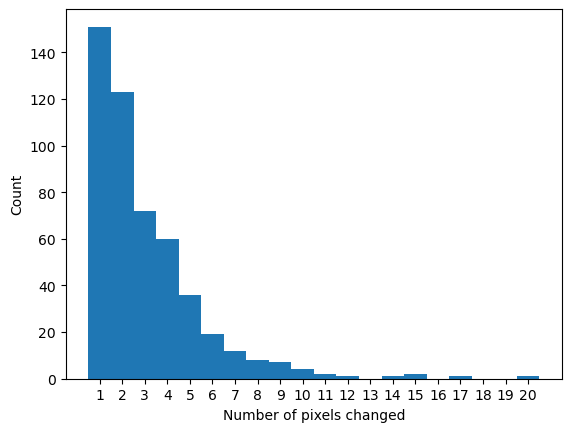

In [229]:
integer_histogram(dist_of_pixels, xlabel="Number of pixels changed")

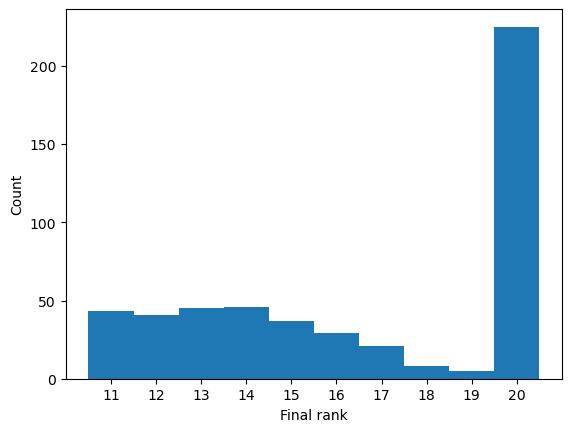

In [230]:
integer_histogram(dist_of_ranks, xlabel="Final rank")

In [6]:
def plot_dist_of_pixels_and_ranks(dist_of_pixels, dist_of_ranks):
    if not t.is_tensor(dist_of_pixels):
        dist_of_pixels = t.tensor(dist_of_pixels)
    if not t.is_tensor(dist_of_ranks):
        dist_of_ranks = t.tensor(dist_of_ranks)
    dist_2d = t.zeros(dist_of_pixels.max() + 1, dist_of_ranks.max() + 1)
    for i in range(len(dist_of_pixels)):
        dist_2d[dist_of_pixels[i], dist_of_ranks[i]] += 1
    plt.imshow(dist_2d)
    plt.xlabel("Final rank")
    plt.ylabel("Number of pixels changed")

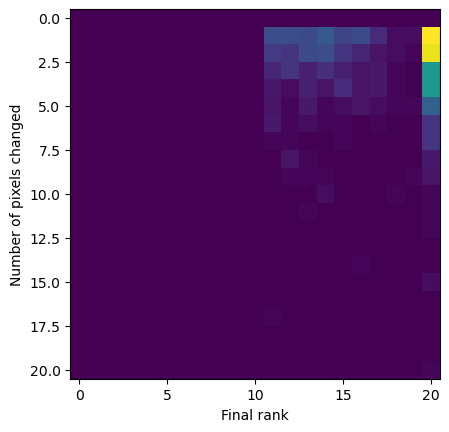

In [232]:
plot_dist_of_pixels_and_ranks(dist_of_pixels, dist_of_ranks)

In [236]:
change_amounts = [0.01, 0.1, 1]
dists_of_ranks = []
dists_of_pixels = []
for change_amount in change_amounts:
    print(f"Change amount: {change_amount}")
    dist_of_pixels, dist_of_ranks = dist_of_pixels_to_change(succeeded, ds, N=500, change_amount=change_amount)
    dists_of_ranks.append(dist_of_ranks)
    dists_of_pixels.append(dist_of_pixels)

Change amount: 0.01


  0%|          | 0/500 [00:00<?, ?it/s]

Failures: 0
Change amount: 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

Failures: 0
Change amount: 1


  0%|          | 0/500 [00:00<?, ?it/s]

Failures: 0


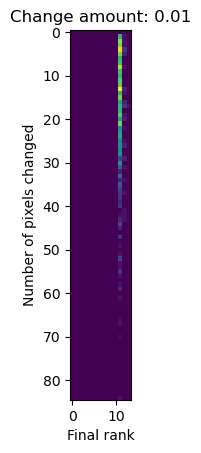

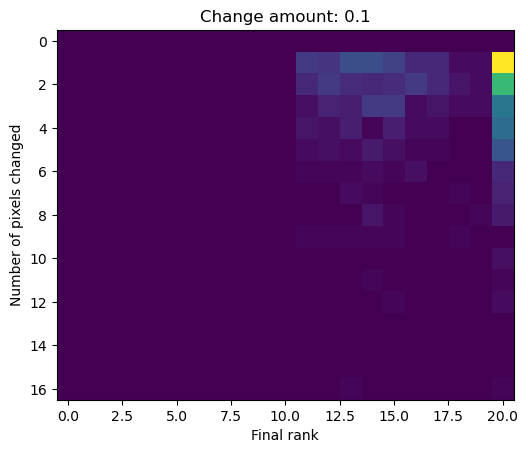

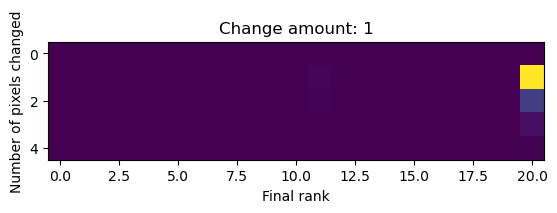

In [237]:
for i, change_amount in enumerate(change_amounts):
    plt.figure()
    plt.title(f"Change amount: {change_amount}")
    plot_dist_of_pixels_and_ranks(dists_of_pixels[i], dists_of_ranks[i])

# Saliency map type stuff attempted

In [8]:
img = ds[1][0]

In [13]:
img.shape

torch.Size([1, 28, 28])

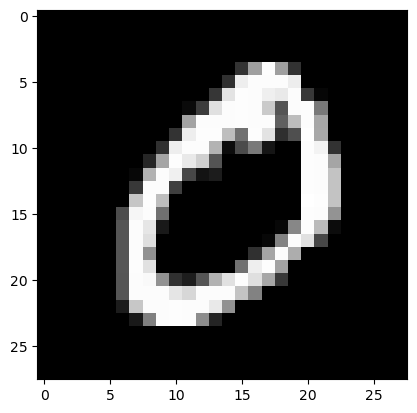

In [14]:
plt.imshow(img[0], cmap="gray")

In [56]:
img2 = t.stack([img, img.clone()])

In [17]:
img2.shape

torch.Size([2, 1, 28, 28])

In [20]:
t.all(img2[0] == img2[1])

tensor(True)

In [21]:
img2[1][0, 0, 0] = 42

In [22]:

t.all(img2[0] == img2[1])

tensor(False)

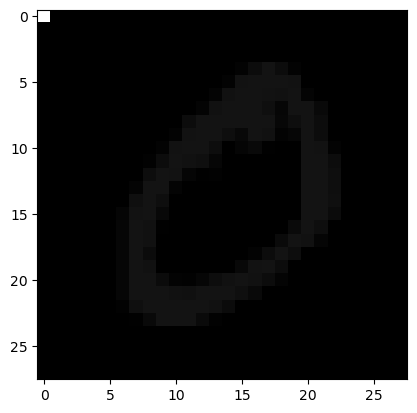

In [24]:
plt.imshow(img2[1, 0], cmap="gray")

In [7]:
def test_rank_change(model, tensor, pos, change_amount):
    tensor2 = tensor.clone()
    rank = model.jacobian_matrix_rank(tensor2)
    tensor2[1][0][pos[0]][pos[1]] += change_amount
    rank2 = model.jacobian_matrix_rank(tensor2)
    return rank != rank2

def min_change_to_change_rank(
    model, img, pos, limit=1000, start=1.0, target_precision=0.01
): 
    twoimg = t.stack([img, img.clone()])
    rank = model.jacobian_matrix_rank(twoimg)
    steps = 0
    int_start = 0.0
    int_end = start
    while not test_rank_change(model, twoimg, pos, int_end):
        int_end *= 2
        if int_end > limit:
            return False, False
    # now we know that the rank changes between int_start and int_end
    while int_end - int_start > target_precision:
        int_mid = (int_start + int_end) / 2
        if test_rank_change(model, twoimg, pos, int_mid):
            int_end = int_mid
        else:
            int_start = int_mid
        steps += 1
        if steps > limit:
            print("Too many steps")
            return False, False
    modified_image = twoimg.clone()
    modified_image[1][0][pos[0]][pos[1]] += int_end
    return int_end, model.jacobian_matrix_rank(
        modified_image
    ).item()

def min_change_to_change_rank_for_all_pixels(model, img, limit=1000, start=1.0, target_precision=0.01):
    # img has size [1, H, W]
    changes = t.log(-t.ones(img.shape[1:]))
    ranks = t.log(-t.ones(img.shape[1:]))
    invalid = t.zeros(img.shape[1:])
    for i in tqdm(range(img.shape[1])):
        for j in range(img.shape[2]):
            changes_ij, ranks_ij = min_change_to_change_rank(model, img, (i, j), limit=limit, start=start, target_precision=target_precision) 
            if changes_ij == False:
                invalid[i, j] = 1
            else:
                changes[i, j] = changes_ij
                ranks[i, j] = ranks_ij
    return changes, ranks, invalid

In [8]:
def plot_mnist_img_sep(models, i, limit=1000, start=1.0, target_precision=0.01):
    img = ds[i][0]
    fig, axs = plt.subplots(1, 1 + 2*len(models), figsize=(20, 7))
    axs[0].imshow(img[0], cmap="gray")
    for i, model in enumerate(models):
        changes, ranks, invalid = min_change_to_change_rank_for_all_pixels(model, img, limit=limit, start=start, target_precision=target_precision)
        numimg = axs[2 * i + 1].imshow(t.log(changes[:, :]))
        fig.colorbar(numimg, ax=axs[2 * i + 1], shrink=0.5)
        rankimg = axs[2 * i + 2].imshow(ranks[:, :], cmap="magma")
        fig.colorbar(rankimg, ax=axs[2 * i + 2], shrink=0.5)
    fig.show()

In [34]:
good_model = succeeded
init_model = BasicCNN()

  0%|          | 0/28 [00:00<?, ?it/s]

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_463822/673775329.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


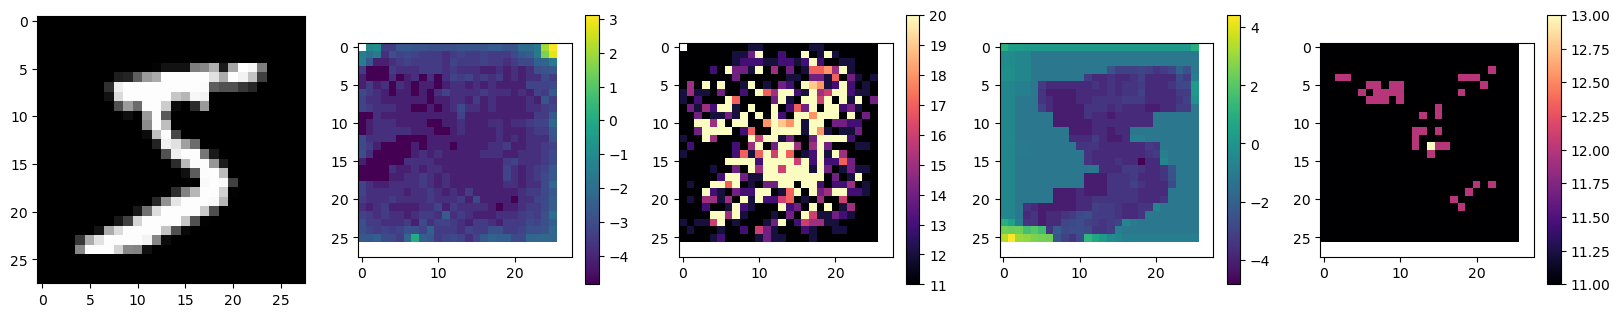

In [35]:
plot_mnist_img_sep([init_model, good_model], 0, limit=1000, start=1.0, target_precision=0.01)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_463822/673775329.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


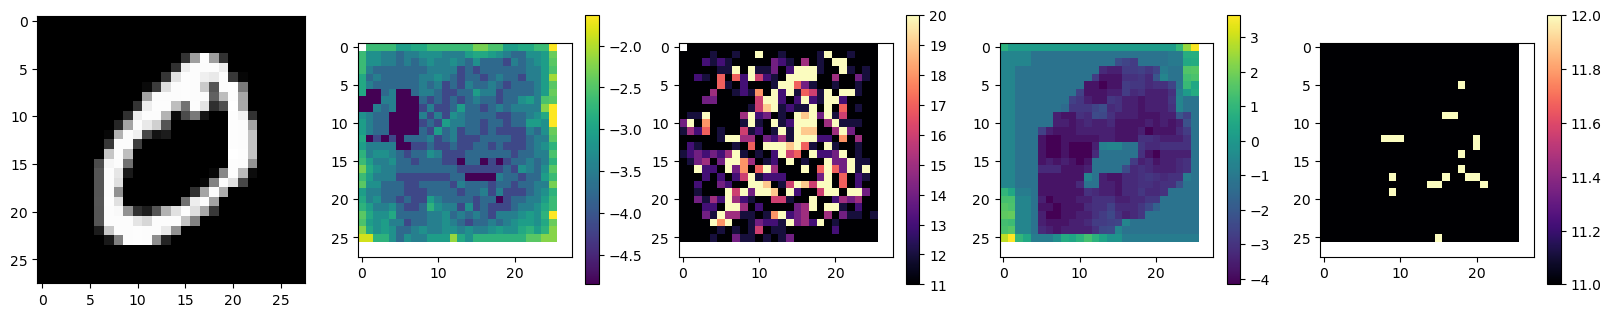

In [36]:
plot_mnist_img_sep([init_model, good_model], 1, limit=1000, start=1.0, target_precision=0.01)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_463822/673775329.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


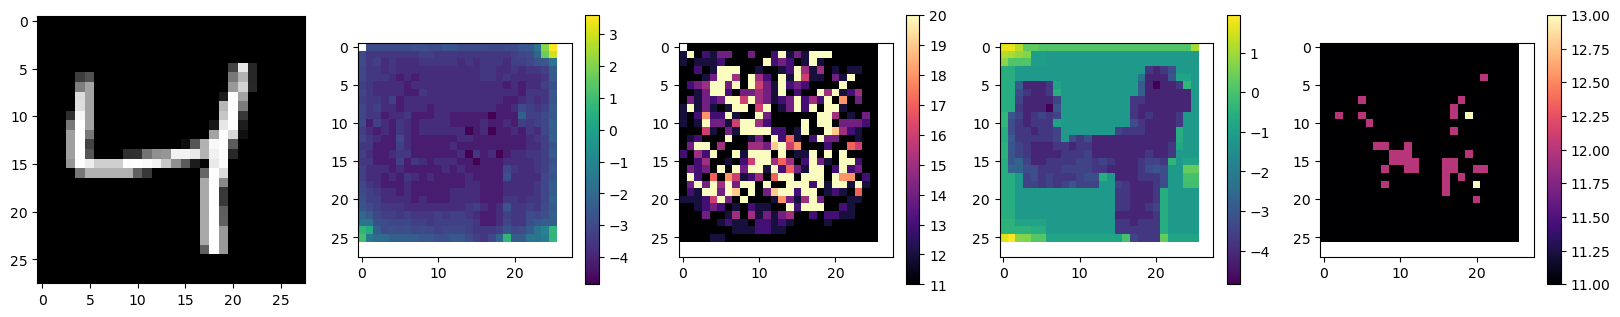

In [37]:
plot_mnist_img_sep([init_model, good_model], 2, limit=1000, start=1.0, target_precision=0.01)

## Same with an MLP model

In [18]:
from dots.models import MNIST_MLP

In [15]:
mnist_mlp = load_model("sleek-sweep-45")

In [19]:
mnist_mlp_init = MNIST_MLP(hidden=[1000])

In [16]:
mnist_mlp

MNIST_MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=10, bias=True)
  )
)

In [20]:
mnist_mlp_init

MNIST_MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=10, bias=True)
  )
)

In [17]:
accuracy(mnist_mlp, ds)

tensor(0.9885)

  0%|          | 0/28 [00:00<?, ?it/s]

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_494329/673775329.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


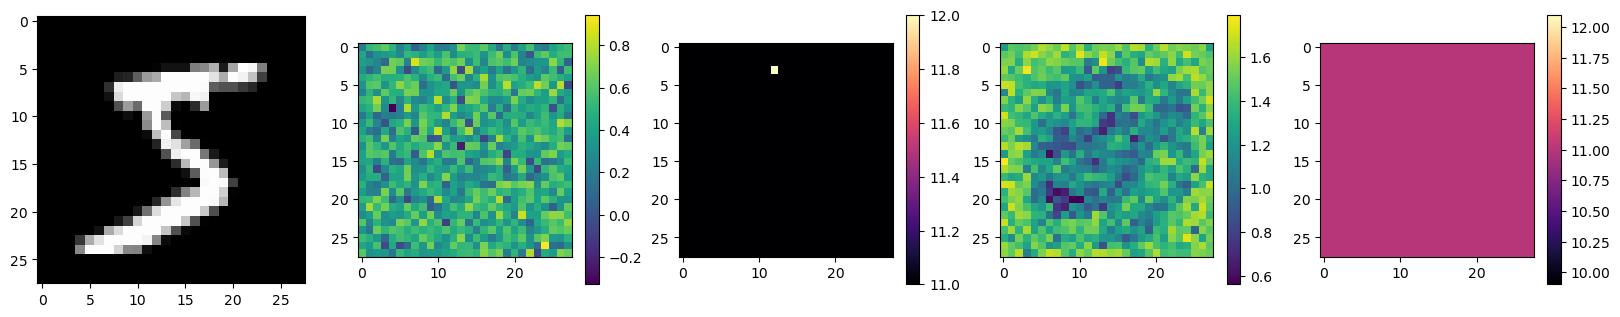

In [21]:
plot_mnist_img_sep([mnist_mlp_init, mnist_mlp], 0, limit=1000, start=1.0, target_precision=0.01)

In [22]:
plot_mnist_img_sep([mnist_mlp_init, mnist_mlp], 1, limit=1000, start=1.0, target_precision=0.01)

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
plot_mnist_img_sep([mnist_mlp_init, mnist_mlp], 2, limit=1000, start=1.0, target_precision=0.01)
